In [1]:
using Revise
using Distributed
using BenchmarkTools
using Plots

using ProgressMeter
using OrdinaryDiffEq
using Statistics: median
# using AbbreviatedStackTraces
using Logging: global_logger
using LinearAlgebra
using TerminalLoggers: TerminalLogger
global_logger(TerminalLogger())
    
include("../scripts/oggm_access.jl")
include("../scripts/1D_SIA.jl")
include("../scripts/1D_SIA_raw.jl") 

2023-06-07 11:10:50: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2023-06-07 11:10:50: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2023-06-07 11:10:50: oggm.cfg: Multiprocessing: using all available processors (N=16)
2023-06-07 11:10:50: oggm.cfg: PARAMS['hydro_month_nh'] changed from `10` to `1`.
2023-06-07 11:10:50: oggm.cfg: PARAMS['continue_on_error'] changed from `False` to `True`.
2023-06-07 11:10:50: oggm.cfg: PARAMS['store_fl_diagnostics'] changed from `False` to `True`.


glacier_evolution_optim (generic function with 1 method)

In [2]:
rgi_ids=["RGI60-11.03643"]
gdirs=init_gdirs(rgi_ids)
gdir=gdirs[1]
gla_name=gdir.name

2023-06-07 11:13:15: oggm.workflow: Execute entity tasks [GlacierDirectory] on 1 glaciers


"Fr4N01236A01 Mer De Glace/Geant"

In [3]:
#Getting the flowlines 
PARAMS["evolution_model"] = "FluxBased" #or SemiImplicit
tasks.init_present_time_glacier(gdir)


fls=gdir.read_pickle("model_flowlines")
bed_o = fls[end].bed_h
surface_o = (fls[end].surface_h)
widths_o = fls[end].widths_m
dx_o = fls[end].dx_meter


diag = gdir.get_diagnostics()
glen_a_o = diag["inversion_glen_a"]
println(glen_a_o)

6.079411329372713e-24


2023-06-07 11:13:48: oggm.cfg: PARAMS['evolution_model'] changed from `SemiImplicit` to `FluxBased`.


In [4]:
#Time parameters
n_years=100.0
tspan = (0.0, n_years*sec_in_year)
y0=2003.0

2003.0

In [5]:
#using the solver

iceflow_sol =glacier_evolution(gdir=gdir, 
                                dx=dx_o, # grid resolution in m
                                nx=length(bed_o),  # grid size
                                width=widths_o,  # glacier width in m 
                                glen_a= glen_a_o,  # ice stiffness 2.4e-24
                                solver = RDPK3Sp35(), #CKLLSRK54_3C()
                                reltol=1e-8,
                                bed_hs=bed_o,
                                surface_ini=surface_o,
                                y0=y0,
                                tspan=tspan)
#using a numerical scheme ("raw")


xc, bed_h, surface_h, years, volume, long =glacier_evolution_optim(gdir=gdir,
                                                                    dx=dx_o,nx=length(bed_o),
                                                                    width=widths_o,
                                                                    glen_a= glen_a_o,
                                                                    bed_h=bed_o,
                                                                    surface_ini=surface_o,
                                                                    n_years=n_years,
                                                                    y0=y0)


#Comparing now with oggm
workflow.execute_entity_task(tasks.run_random_climate, gdir, y0 = y0, nyears=n_years,
                                seed=1,store_fl_diagnostics=true)

2023-06-07 11:24:44: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers


1-element Vector{PyObject}:
 PyObject <oggm.core.flowline.FluxBasedModel object at 0x7f80b3893850>

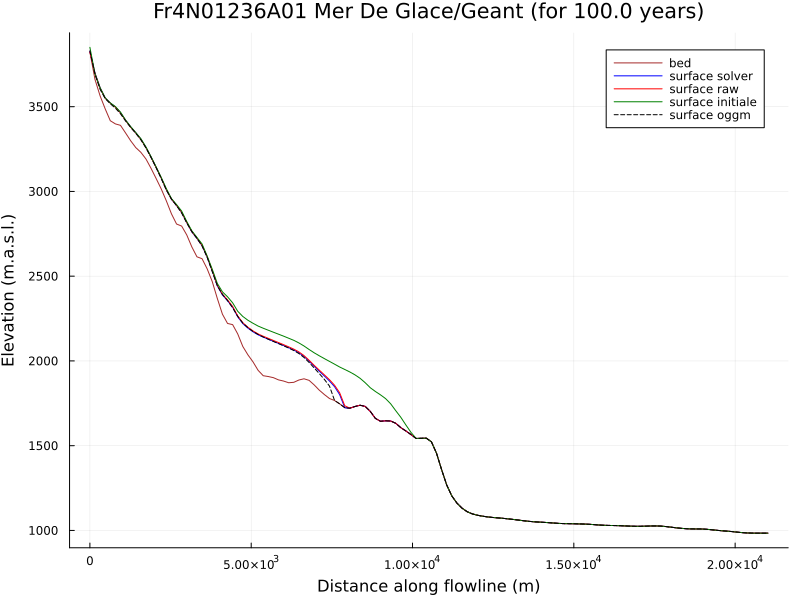

In [8]:
#Plotting everything
begin
    
    plot(xc,bed_o, c="brown",label="bed",title="$gla_name (for $n_years years)",ylabel="Elevation (m.a.s.l.)")
    plot!(xc,iceflow_sol[end] .+ bed_o, c="blue",label="surface solver",size=(800, 600),
    xlabel="Distance along flowline (m)")
    
    plot!(xc,surface_h, color="red", label="surface raw")
    plot!(xc,surface_o,color="green",label="surface initiale")

    f = gdir.get_filepath("fl_diagnostics")
    ds = xr.open_dataset(f,group="fl_0")
    plot!(xc,ds["bed_h"].data+ds["thickness_m"].data[Int(n_years+1),:],linestyle=:dash,color="black",
                                                    label="surface oggm")

end 